In [1]:
import math

import numpy as np
import scipy.ndimage as ndi
import skimage.exposure
import skimage.morphology
from skimage import io
from skimage import measure
from skimage.filters import thresholding
from skimage.transform import resize

from skimage.color import rgb2gray
from matplotlib import pyplot as plt

In [2]:
def DiameterofROI(I):
    # Extracting red channel
    R = I[:, :, 0]
    # Median filtering (7x7)
    ROI = ndi.median_filter(R, (7, 7))
    # Otsu thresholding
    level = skimage.filters.threshold_otsu(ROI)
    # Creating binary ROI mask
    ROI = ROI > (level / 5)
    # Binary erosion (contracting ROI)
    for i in range(3):
        ROI = skimage.morphology.binary_erosion(ROI)
    # Finding ROI diameter - first white pixel
    for j in range(0, ROI.shape[1]):
        for i in range(0, ROI.shape[0]):
            if ROI[i][j] > 0:
                [x2, y2] = [i, j]
                break
    # Finding ROI diameter - last white pixel
    for j in range(ROI.shape[1] - 1, 0, -1):
        for i in range(ROI.shape[0] - 1, 0, -1):
            if ROI[i][j] > 0:
                [x1, y1] = [i, j]
                break
    # Diameter estimate
    D = y2 - y1
    return ROI, D

In [18]:
def show_img(img):
    skimage.io.imshow(img)
    skimage.io.show()

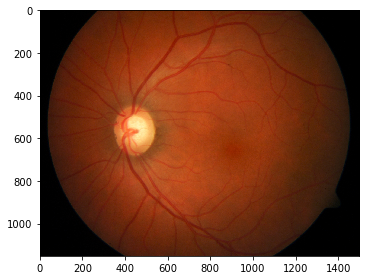

In [22]:
img = skimage.io.imread('C:/Users/LaraLiL/Desktop/image090.jpg')  # change to parameter
ROI, D = DiameterofROI(img)
show_img(img)

In [3]:
def ResizeImage(Im, oldSizeOfROI, newSizeOfROI):
    # Calculating zoom
    zoom = newSizeOfROI / oldSizeOfROI
    # New height and width
    height = int(Im.shape[0] * zoom)
    width = int(Im.shape[1] * zoom)
    # Resizing image
    newIm = skimage.transform.resize(Im, (height, width))
    return newIm

In [4]:
def PreProcessingToEntropy(image, size):
    # Median filtering the green channel (3x3)
    medifilt_I = ndi.median_filter(image[:, :, 1], (size, size))
    # Preforming contrast limited adaptive histogram equalization
    preProcessed_Im = skimage.exposure.equalize_adapthist(medifilt_I, clip_limit=0.1)
    return preProcessed_Im

In [5]:
def EntropyOfImage(image, windSize):
    # Image dimensions
    [height, width] = [image.shape[0], image.shape[1]]
    # Entropy image initialization
    entIm = np.zeros((height, width))
    # Calculating Shannon entropy for each pixel
    for i in range(0, height):
        for j in range(0, width):
            fromI = i - windSize
            fromJ = j - windSize
            toI = i + windSize
            toJ = j + windSize
            if fromI < 1:
                fromI = 1
            if fromJ < 1:
                fromJ = 1
            if toI > height:
                toI = height
            if toJ > width:
                toJ = width
            window = image[fromI:toI, fromJ: toJ]
            entIm[i, j] = measure.shannon_entropy(window)
    # Normalizing entropy
    entIm = entIm / 8.0
    return entIm

In [29]:
def HighLightBrightObjects(newIm):
    # Extracting green channel
    green = newIm[:, :, 1]
    # Performing contrast limited adaptive histogram equalization
    green = skimage.exposure.equalize_adapthist(green)
    # 2D discrete Fourier transformation
    Y = np.fft.fft2(green)
    # Shifts zero-frequency terms to the center
    Y = np.fft.fftshift(Y)
    # Image dimensions
    [m, n] = [green.shape[0], green.shape[1]]
    # Creating a mask for the low frequencies
    seged = np.zeros((m, n))
    seged[math.ceil(m / 2), math.ceil(n / 2)] = 1
    SE = skimage.morphology.disk(5)
    seged = skimage.morphology.binary_dilation(seged, SE)
    # Removing high frequencies
    Y[seged == 0] = 0
    # 2D inverse discrete Fourier transformation
    res = np.fft.ifft2(Y)
    # Absolute value of the complex image
    intIm = np.abs(res)
    return intIm

In [30]:
def LocalizeOpticDisc(entIm, numberOfCandidates):
    MAX = entIm.max()
    level = 0.95  # skimage.filters.threshold_otsu(entIm[entIm > 0]) / 255
    thr = level * MAX
    # print(MAX)
    # print(level)
    # print(thr)

    N = 0
    mod = 0
    L = np.zeros(entIm.shape)
    BW = np.zeros(entIm.shape)
    while (N < numberOfCandidates) and (mod < min((1 - level), 0.1)):
        BW = entIm > thr
        L = skimage.measure.label(BW, connectivity=2)
        N = L.max()
        mod = mod + 0.01
        thr = (level + mod) * MAX

    if N == 1:
        BW = entIm > (level * MAX)
        L = skimage.measure.label(BW, connectivity=2)
        N = L.max()

    Features = np.zeros((N + 1, 7))
    i = 1
    for i in range(1, N + 1, 1):
        BW = L == i
        # i. folt pixeleinek száma
        Features[i, 1] = np.sum(BW)

        BW2 = BW ^ skimage.morphology.binary_erosion(BW)
        # i. folt kerülete
        Features[i, 2] = np.sum(BW2)

        # i. folt kompaktsága
        Features[i, 3] = ((4 * math.pi * Features[i, 1]) / (Features[i, 2] * Features[i, 2]))

        Features[i, 4] = Features[i, 1] * Features[i, 3]

        # i. folt átlagos intenzitása
        Features[i, 5] = np.mean(entIm[L == i])

        Features[i, 6] = Features[i, 4] * Features[i, 5]

    n = min([numberOfCandidates, i])
    acc = np.zeros(n)

    for j in range(0, n, 1):
        [val, ind] = Features[:, 6].max(), Features[:, 6].argmax()
        acc[j] = val
        Features[ind, :] = 0

    return BW, acc


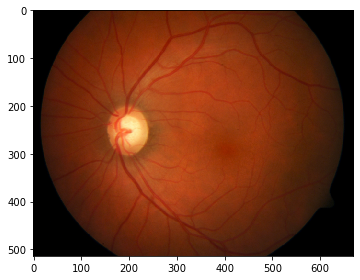

In [31]:
newIm = ResizeImage(img, D, 630)
show_img(newIm)

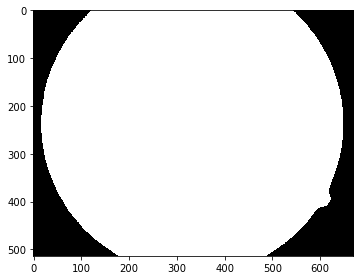

In [32]:
newROI = ResizeImage(ROI, D, 630)
show_img(newROI)

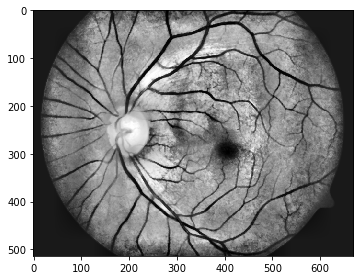

In [33]:
prepIm = PreProcessingToEntropy(newIm, 3)
show_img(prepIm)

M:\Programs\Anaconda\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


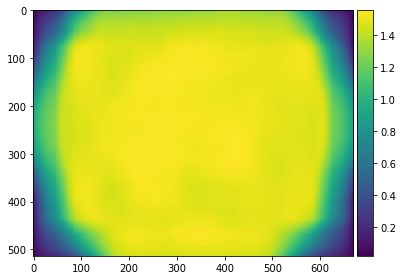

In [34]:
entIm = EntropyOfImage(prepIm, 45)
show_img(entIm)

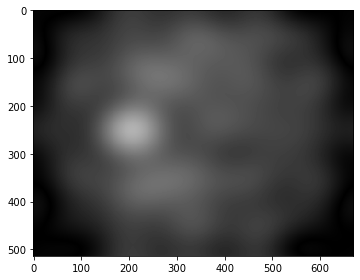

In [35]:
intIm = HighLightBrightObjects(newIm)
show_img(intIm)

<ipython-input-36-9707ebf54967>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  grayscale = rgb2gray(image)


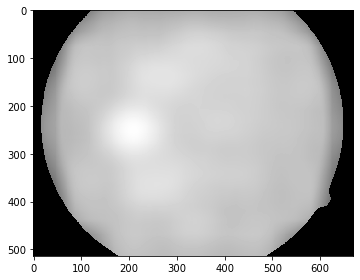

In [36]:
result = (entIm + intIm) / 2.0
result[newROI == 0] = 0.0
img_data = 255 * result / result.max()
img_out = img_data.astype(np.uint8)
image=img_out
grayscale = rgb2gray(image)
show_img(grayscale)

M:\Programs\Anaconda\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


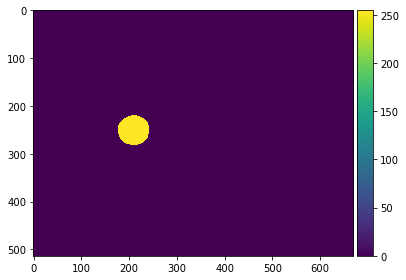

In [37]:
mask_img, acc = LocalizeOpticDisc(grayscale, 1)
img_data = 255 * mask_img
show_img(img_data)